# TReNDS NeuroImaging
Prediction of multiple assessments plus age from multimodal brain MRI features using image analysis from IR representation of all the corresponding spatial maps. This notebook is for model setup, training and evaluation/prediction. 
<br>
<br>
More information about the project is found [here](https://www.kaggle.com/c/trends-assessment-prediction/overview/description).

## Score Evaluation
The score, $\mathcal{S}$, is evaluated through the feature-weighted, normalized absolute error defined as
\begin{equation}
\mathcal{S} = \sum_f w_f \left(\frac{\sum_i \left|y_{f,i} - \hat{y}_{f,i}\right|}{\sum_i \hat{y}_{f,i}}\right),
\end{equation}
<br>
where $y_{f,i}$ and $\hat{y}_{f,i}$ is the $i^{th}$ observation and prediction of feature $f$ respectively and the $w_f$ is the weight given to each of the five features with fixed values of
\begin{equation}
\mathbf{w} = \left[0.3, 0.175, 0.175, 0.175, 0.175\right]^T,
\end{equation}
<br>
corresponding to the features $\mathbf{f} = [\text{age}, \text{ domain1_var1}, \text{ domain1_var2}, \text{ domain2_var1}, \text{ domain2_var2}]^T$


## Model Explanation
The initial model used in this kernel is the [squeezenet](https://arxiv.org/abs/1602.07360) architecture with motivation of its low memory requirement due to less amount of parameters. As concluded in [this paper](https://arxiv.org/pdf/1810.00736.pdf) which analysed benchmarks of representative
deep neural network architectures, squeezenet achieved best score of 1% accuracy per million parameters as shown in the figure below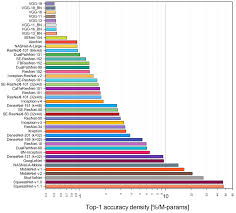
<br>
<br>
Squeezenets are fully convolutional and uses [Fire modules](https://www.researchgate.net/figure/The-structure-of-the-Fire-module-used-in-SqueezeNet_fig4_328548960) which has a squeeze layer of $1x1$ convolutions that drastically reduce the amount of parameters. This allows them to be trained on more complex image structures than a corresponding depth of another architecture before the local memory is overfilled.
<br>
<br>
**HOWEVER**, the squeezenet performed too poorly in order to be a satisfactory solution to the problem. Therefore, a customized [ResNet](https://arxiv.org/pdf/1512.03385.pdf) was used instead modified in order to fit the hardware limitations. 
<br>
<br>
The weights are initialized using [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) which samples uniformly from $\mathcal{U}\left(-a, a\right)$ where
<br>
\begin{equation}
a := \mathcal{G}\sqrt{\frac{6}{n_j+n_{j+1}}},
\end{equation}
<br>
where $\mathcal{G}$ is a gain factor that varies depending on the acivation function of the layer/function. For linear and conv layers the gain factor value is set to $\mathcal{G} = 1$ whereas for the ReLU function the value is set to $\mathcal{G} = \sqrt{2}$.
<br>
<br>
Furthermore, during training the learning rate is reduced by $10^{-1}$ after each epoch.

In [1]:

# General packages
import pandas as pd
import os
import gc
import random
import seaborn as sns
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
import h5py
import random
from random import randint
import time

# PyTorch packages
import torch
import torch.nn.init as init

import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms



import warnings
warnings.filterwarnings("ignore")


## DataLoaders

In [2]:
class TReNDSDataset(Dataset):
    def __init__(self, data, targets, map_path, train):
        self.data = data
        self.train = train
        self.map_path = map_path
        self.map_id = self.data.Id
        if train: self.targets = targets
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.map_path + str(self.map_id[idx])
        all_maps = h5py.File(path + '.mat', 'r')['SM_feature'][()]
        cols = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
        
        idx_1, idx_2, idx_3 = randint(0, 51), randint(0, 62), randint(0, 52)
        proj_1 = cv2.resize(all_maps[:, idx_1, :, :].transpose(1, 2, 0), (config.size, config.size))
        proj_2 = cv2.resize(all_maps[:, :, idx_2, :].transpose(1, 2, 0), (config.size, config.size))
        proj_3 = cv2.resize(all_maps[:, :, :, idx_3].transpose(1, 2, 0), (config.size, config.size))
        features = np.concatenate([proj_1, proj_2, proj_3], axis=2).transpose(2, 0, 1)
      
        
        if not self.train:
            return torch.FloatTensor(features)
        else:
            i = self.map_id[idx]
            targets = self.targets.query('Id == {}'.format(i)).values
            targets = np.repeat(targets[:, 1:], 159, 0).reshape(-1, 5)
            return torch.FloatTensor(features), torch.FloatTensor(targets)

## Configuration 

In [3]:
class config:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #device = torch.device('cpu')
    epochs = 6
    dataset_split = 0.8
    init_lr = 1e-3
    save_path = 'rn_model.pt'
    size = 128
    batch_size = 32
    val_batch_size = 32
    num_classes = 5
    
    base_path = '../input/trends-assessment-prediction/'
    train_maps_path = base_path + 'fMRI_train/'
    test_maps_path = base_path + 'fMRI_test/'
    
    feat_path = base_path + 'fnc.csv'
    targ_path = base_path + 'train_scores.csv'
    submission_path = base_path + 'sample_submission.csv'
    



## Simple preprocessing
Since the data itself was clean as seen in the visualization kernel, no advanced feature engineering is **necessary**. 

In [4]:


test_Ids = [map_id[:-4] for map_id in sorted(os.listdir(config.test_maps_path))]
train_Ids = [map_id[:-4] for map_id in sorted(os.listdir(config.train_maps_path))]

targets = pd.read_csv(config.targ_path)
targets = targets.fillna(targets.mean())
submission_file = pd.read_csv(config.submission_path)

features = pd.read_csv(config.feat_path)
test_df = features.query('Id in {}'.format(test_Ids)).reset_index(drop=True)
train_df = features.query('Id in {}'.format(train_Ids)).reset_index(drop=True)
targets.head()
print(len(test_Ids))


5877


# Model

In [5]:

#### ResNet
def conv3(in_channels, out_channels, stride=1, kernel_size=1, padding=0, padding_mode=False):
      return (nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding,
                       stride=stride, bias=False) if (padding_mode == False) else
              (nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                       stride=stride, bias=False, padding_mode="replicate")))

  # Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv1 = conv3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3(out_channels, out_channels, kernel_size=1, padding_mode=True)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = conv3(out_channels, out_channels)
        self.drop = nn.Dropout(0.5)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.bn(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=29, channels=3):
        super(ResNet, self).__init__()
        self.channels = channels
        self.in_channels = 32
        self.bn = nn.BatchNorm2d(self.channels)
        self.conv = conv3(self.channels, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.layer1 = self.make_layer(block, 32, layers[0])
        self.layer2 = self.make_layer(block, 64, layers[1])
        self.layer3 = self.make_layer(block, 128, layers[2])
        self.layer4 = self.make_layer(block, 256, layers[3])
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm1d(6272)
        self.max_pool2 = nn.AvgPool2d(8)
        self.fc1 = nn.Linear(6272, 512)
        self.fc2 = nn.Linear(512, num_classes)
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #init.normal_(m.weight, mean=0.0, std=0.01)
                init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                   # init.constant_(m.bias, 0)
                    init.ones_(m.bias)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
            conv3(self.in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn(x)
        out = self.conv(x)
        out = self.bn1(out)
        out = self.max_pool1(out)

        out = self.drop(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.drop(out)
        out = self.layer3(out)
        out = self.drop(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.max_pool2(out)
        out = self.drop(out)

        out = out.view(out.size(0), -1)
        out = self.bn3(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

def custom_resnet(print_net=True):
    net_args_resnet = {
    "block": ResidualBlock,
    "layers": [3, 4, 6, 4],
    "num_classes": 5,
    "channels": 159
    }
    model = ResNet(**net_args_resnet)
    if print_net:
        temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'The model architecture:\n\n', model)
        print(f'\nThe model has {temp:,} trainable parameters')

    return model


In [6]:
def weighted_nae(inp, targ):
    W = torch.FloatTensor([0.3, 0.175, 0.175, 0.175, 0.175]).to(config.device)

    return torch.mean(torch.matmul(torch.abs(inp - targ), W/torch.mean(targ, axis=0)))



In [7]:
split = int(config.dataset_split*len(train_df))
val = train_df[split:].reset_index(drop=True)
train = train_df[:split].reset_index(drop=True)




test_set = TReNDSDataset(test_df, None, config.test_maps_path, False)
test_loader = DataLoader(test_set, batch_size=config.val_batch_size)

In [8]:
train.head()

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.368580,0.166876,0.438148,0.341007,-0.186251,0.049096,0.121417,-0.174268,-0.231578,...,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,0.151696,-0.024819,0.217504,0.418072,-0.227234,-0.064052,-0.143832,-0.118116,-0.054825,...,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10004,0.132793,0.258255,0.490769,0.342717,0.091112,0.107969,0.029220,-0.026237,0.094742,...,-0.130339,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358
3,10005,0.291921,0.251254,0.416470,0.511719,-0.362626,-0.164710,-0.289059,-0.015537,-0.087316,...,-0.139525,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898
4,10007,0.023588,0.251784,0.571558,0.338475,-0.104604,-0.199365,-0.241106,-0.190934,-0.028470,...,-0.150218,0.408926,0.072004,0.157582,0.532046,0.355448,0.462675,0.161005,0.703679,0.293607


In [9]:
def logger(elapsed_time, batch_idx, n_batches, epoch, epochs, loss):
    tim = 'seconds'
    if elapsed_time > 60 and elapsed_time <= 3600:
        elapsed_time /= 60
        tim = 'minutes'
    elif elapsed_time > 3600:
        elapsed_time /= 3600
        tim = 'hours'
    elapsed_time = format(elapsed_time, '.2f')
    print(f'Elapsed time: {elapsed_time} {tim}\tBatch: {batch_idx}/{n_batches}\tEpoch: {epoch+1}/{epochs}\tTraining Loss: {loss:.4f}')

In [10]:
def train_loop(model):
   
    val_set = TReNDSDataset(val, targets, config.train_maps_path, True)
    val_loader = DataLoader(val_set, batch_size=config.val_batch_size)
    train_set = TReNDSDataset(train, targets, config.train_maps_path, True)
    train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    
    model = model.to(config.device)
    lr = config.init_lr
    
    start_time = time.time()
    loss = 0
    best=1.0
    training_loss, validation_loss = [], []
    total, success = 0,0
    val_total, val_success = 0,0
    
    for epoch in range(config.epochs):
        optimizer = Adam(model.parameters(), lr=lr*10**(-epoch), amsgrad=False)
        print(f'Learning rate set to {lr*10**(-epoch)}')

        for batch_i, train_batch in enumerate(train_loader):
            train_img, train_targs = train_batch
            train_img = train_img.to(config.device)
            train_targs = train_targs.to(config.device)
            logger(time.time()-start_time, batch_i, len(train_loader), epoch, config.epochs, loss)
           
            model.train()
            outputs = model.forward(train_img)
            
            train_targs = train_targs[:,0,:].reshape(train_targs.shape[0], train_targs.shape[2])
            loss = weighted_nae(outputs, train_targs)

            
            training_loss.append(loss)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            del train_img
            del train_targs
            del outputs
            gc.collect()
            

        model.eval()
        val_preds, val_targs, val_acc = [], [], []
        print('Validating...')
        for val_iter, val_batch in enumerate(val_loader):
            print(f'Iteration: {val_iter}/{len(val_loader)}')
            val_img, val_targ = val_batch
            val_targ = val_targ[:,0,:].reshape(val_targ.shape[0], val_targ.shape[2])
            val_img, val_targ = val_img.to(config.device), val_targ.to(config.device)


            with torch.no_grad():
                model = model.to(config.device)
                val_outputs = model.forward(val_img)
                val_preds.append(val_outputs); val_targs.append(val_targ)

                del val_outputs
                del val_targ
                del val_img

        val_preds = torch.cat(val_preds, axis=0)
        val_targs = torch.cat(val_targs, axis=0)
        val_loss = weighted_nae(val_preds, val_targs)
        validation_loss.append(val_loss)
        if val_loss < best:
            best = val_loss
            print('Saving model...')
            torch.save(model.state_dict(),  config.save_path)
            print(f'Model weights saved at "{config.save_path}"')

        print(f'Validation loss for epoch {epoch+1}: {val_loss:.4f}')

        gc.collect()
    

            
    return model, training_loss, validation_loss



In [11]:
model = custom_resnet(True)

The model architecture:

 ResNet(
  (bn): BatchNorm2d(159, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Conv2d(159, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (drop): Dropout(p=0.5, inplace=False)
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False, padding_mode=replicate)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv

In [12]:

model, training_loss, validation_loss = train_loop(model)

Learning rate set to 0.001
Elapsed time: 11.83 seconds	Batch: 0/147	Epoch: 1/6	Training Loss: 0.0000
Elapsed time: 25.02 seconds	Batch: 1/147	Epoch: 1/6	Training Loss: 1.0002
Elapsed time: 37.26 seconds	Batch: 2/147	Epoch: 1/6	Training Loss: 0.9999
Elapsed time: 49.16 seconds	Batch: 3/147	Epoch: 1/6	Training Loss: 0.9987
Elapsed time: 1.01 minutes	Batch: 4/147	Epoch: 1/6	Training Loss: 0.9964
Elapsed time: 1.21 minutes	Batch: 5/147	Epoch: 1/6	Training Loss: 0.9928
Elapsed time: 1.41 minutes	Batch: 6/147	Epoch: 1/6	Training Loss: 0.9882
Elapsed time: 1.61 minutes	Batch: 7/147	Epoch: 1/6	Training Loss: 0.9803
Elapsed time: 1.81 minutes	Batch: 8/147	Epoch: 1/6	Training Loss: 0.9718
Elapsed time: 2.00 minutes	Batch: 9/147	Epoch: 1/6	Training Loss: 0.9588
Elapsed time: 2.19 minutes	Batch: 10/147	Epoch: 1/6	Training Loss: 0.9458
Elapsed time: 2.40 minutes	Batch: 11/147	Epoch: 1/6	Training Loss: 0.9230
Elapsed time: 2.60 minutes	Batch: 12/147	Epoch: 1/6	Training Loss: 0.8989
Elapsed time: 2.7

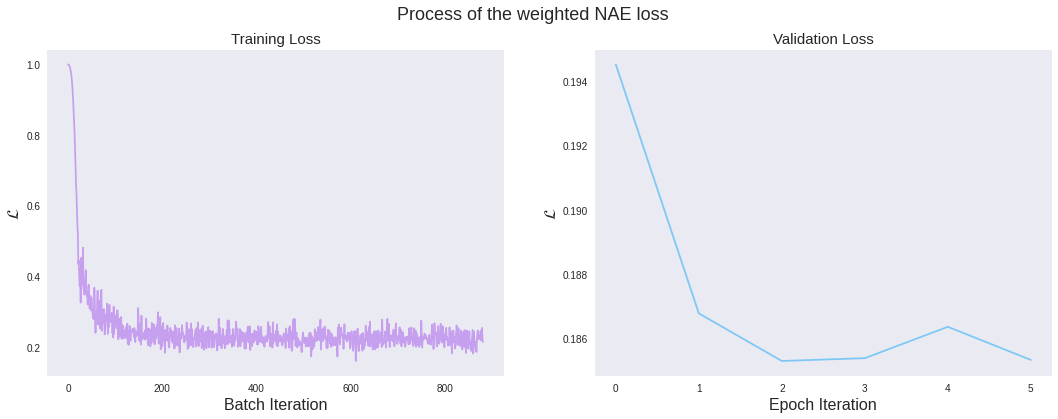

In [13]:
import matplotlib._color_data as mcd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
c1 = mcd.XKCD_COLORS["xkcd:" + "lavender"].upper()
c2 = mcd.XKCD_COLORS["xkcd:" + "lightblue"].upper()
c3 = mcd.XKCD_COLORS["xkcd:" + "aqua"].upper()

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(training_loss, color=c1)
ax[0].set_title(f'Training Loss', fontsize=15)
ax[0].grid()
ax[0].set_ylabel('$\mathcal{L}$', fontsize=16)
ax[0].set_xlabel('Batch Iteration', fontsize=16)


ax[1].plot(validation_loss, color=c2)
ax[1].set_title(f'Validation Loss', fontsize=15)
ax[1].grid()
ax[1].set_ylabel('$\mathcal{L}$', fontsize=16)
ax[1].set_xlabel('Epoch Iteration', fontsize=16)


fig.suptitle('Process of the weighted NAE loss', fontsize=18)

plt.show()


In [14]:
len(validation_loss)

6

In [15]:
%%time
pred_model = custom_resnet(False)
try:
    pred_model.load_state_dict(torch.load(config.save_path))
except Exception as e:
    print(f'Exception occured when trying to load model weights...\n{e}')

pred_model.eval()
pred_model = pred_model.to(config.device)
test_predictions = []
print('Predicting test data...')
for i, test_img in enumerate(test_loader):
    print(f'Iteration nr: {i}/{len(test_loader)}')
    test_img = test_img.to(config.device)
    with torch.no_grad():
        test_predictions.append(pred_model.forward(test_img))
        

avg_preds = []
test_predictions = torch.cat(test_predictions, axis=0)
for idx in range(0, len(test_predictions), 159):
    avg_preds.append(test_predictions[idx:idx+159].mean(axis=0))

preds =  torch.stack(avg_preds, axis=0).detach().cpu().numpy()

Predicting test data...
Iteration nr: 0/184
Iteration nr: 1/184
Iteration nr: 2/184
Iteration nr: 3/184
Iteration nr: 4/184
Iteration nr: 5/184
Iteration nr: 6/184
Iteration nr: 7/184
Iteration nr: 8/184
Iteration nr: 9/184
Iteration nr: 10/184
Iteration nr: 11/184
Iteration nr: 12/184
Iteration nr: 13/184
Iteration nr: 14/184
Iteration nr: 15/184
Iteration nr: 16/184
Iteration nr: 17/184
Iteration nr: 18/184
Iteration nr: 19/184
Iteration nr: 20/184
Iteration nr: 21/184
Iteration nr: 22/184
Iteration nr: 23/184
Iteration nr: 24/184
Iteration nr: 25/184
Iteration nr: 26/184
Iteration nr: 27/184
Iteration nr: 28/184
Iteration nr: 29/184
Iteration nr: 30/184
Iteration nr: 31/184
Iteration nr: 32/184
Iteration nr: 33/184
Iteration nr: 34/184
Iteration nr: 35/184
Iteration nr: 36/184
Iteration nr: 37/184
Iteration nr: 38/184
Iteration nr: 39/184
Iteration nr: 40/184
Iteration nr: 41/184
Iteration nr: 42/184
Iteration nr: 43/184
Iteration nr: 44/184
Iteration nr: 45/184
Iteration nr: 46/184

In [16]:
print(test_predictions.flatten())

tensor([51.4418, 54.5243, 61.8456,  ..., 61.9911, 48.3727, 53.9399],
       device='cuda:0')


In [17]:
len(test_predictions)*5

29385

In [18]:
print(len(submission_file))

29385


In [19]:
submission_file.head()


,Id,Predicted
0,10003_age,50.0
1,10003_domain1_var1,50.0
2,10003_domain1_var2,50.0
3,10003_domain2_var1,50.0
4,10003_domain2_var2,50.0


In [20]:
submission_file.Predicted = test_predictions.flatten().cpu().numpy()*0.1276
s = submission_file.copy()


In [21]:
submission_file.to_csv('submission.csv', index=False)


In [22]:
submission_file.head()

,Id,Predicted
0,10003_age,6.563970
1,10003_domain1_var1,6.957299
2,10003_domain1_var2,7.891496
3,10003_domain2_var1,6.148953
4,10003_domain2_var2,6.851381


In [23]:
s.Predicted = test_predictions.flatten().cpu().numpy()

In [24]:
s.Predicted

0        51.441769
1        54.524288
2        61.845581
3        48.189285
4        53.694210
           ...    
29380    51.822346
29381    54.814388
29382    61.991089
29383    48.372734
29384    53.939896
Name: Predicted, Length: 29385, dtype: float32

In [25]:
s.to_csv('./submission.csv', index=False)